<font size="6"><center>**Walk-through**</font>

This notebooks attemps to guide newcomer quants in their first steps to become rich

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run ../nb_config.py

running notebook configuration


In [3]:
import numpy as np
import pandas as pd
import os

# Parameters

In [4]:

start_dt = pd.Timestamp('2015-01-01')
end_dt = pd.Timestamp('2017-12-31')
tau = 5

In [5]:
ticker = 'AMZN'

# Load Data

`folder structure:`  
|-notebooks/  
|-data/  
|--raw/  
|---wiki_prices.csv

In [6]:
wiki_prices_path = os.path.join("..", "data", "raw", "wiki_prices.csv")  #
wiki_prices = pd.read_csv(wiki_prices_path, parse_dates=['date'], index_col=['ticker', 'date'])

In [7]:
pd.concat([wiki_prices.head(2), wiki_prices.tail(2)], axis=0)

open    high     low   close          volume  \
ticker date                                                         
A      1999-11-18 45.5000 50.0000 40.0000 44.0000 44,739,900.0000   
       1999-11-19 42.9400 43.0000 39.8100 40.3800 10,897,100.0000   
ZUMZ   2018-03-26 23.7500 24.8000 23.7000 24.6500    375,320.0000   
       2018-03-27 24.6500 24.6500 23.3500 23.6000    403,884.0000   

                   ex-dividend  split_ratio  adj_open  adj_high  adj_low  \
ticker date                                                                
A      1999-11-18       0.0000       1.0000   31.0420   34.1120  27.2896   
       1999-11-19       0.0000       1.0000   29.2954   29.3363  27.1600   
ZUMZ   2018-03-26       0.0000       1.0000   23.7500   24.8000  23.7000   
       2018-03-27       0.0000       1.0000   24.6500   24.6500  23.3500   

                   adj_close      adj_volume  
ticker date                                   
A      1999-11-18    30.0186 44,739,900.0000  
       1999-11-19    27.5489 10,897,100.0000  
ZUMZ   2018-03-26    24.6500    375,320.0000  
       2018-03-27    23.6000    403,884.0000

In [8]:
wiki_prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 15389314 entries, ('A', Timestamp('1999-11-18 00:00:00')) to ('ZUMZ', Timestamp('2018-03-27 00:00:00'))
Columns: 12 entries, open to adj_volume
dtypes: float64(12)
memory usage: 1.4+ GB


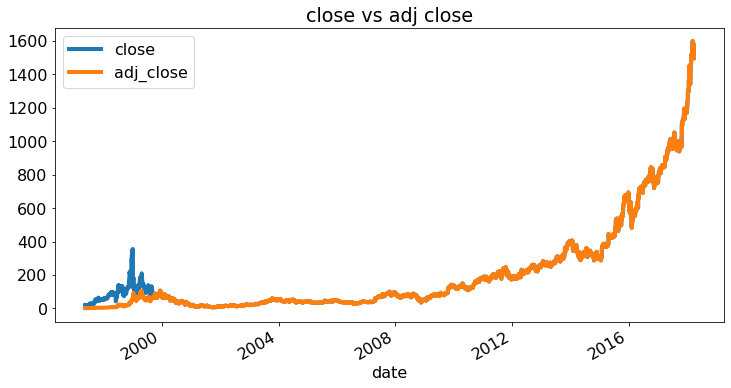

In [9]:
wiki_prices.loc[ticker, ['close', 'adj_close']].plot()
plt.title('close vs adj close')
plt.show()

Use variable adj to simplify. Data Provider computes this figures to take into account splits, dividends and other corporte operations. This computation is perform from a single day point of view, so it is constantly updated

# Data Preparation

In [10]:
# compute a rolling mean for each group
avol = (
    wiki_prices
    .groupby('ticker')['adj_volume']
    .transform(lambda grp: grp.rolling(30).mean())
)

Full ticker population is very large, however some tickers may be quite illiquid (hard to trade at any time, due to offer/demand shortages). To overcome this, we can focus on highly trade tickers, therefore, to get a proxy of highly liquid stocks, a rolling average of volume can be obtained and then filter the stock population. This computation must be carried out daily

Only rolling volume computation is given as an example :)

In [11]:
avol.loc[ticker].tail()

date
2018-03-21   5,628,515.9333
2018-03-22   5,598,879.5667
2018-03-23   5,590,059.7667
2018-03-26   5,315,384.1667
2018-03-27   5,319,086.3333
Name: adj_volume, dtype: float64

In [12]:
avol_ex = (wiki_prices
 .loc[ticker, 'adj_volume']
 .iloc[-30:]  # try to never subset twice
 .mean()
)
avol_ex

5319086.333333333

In [13]:
avol.loc[ticker].iloc[-1]

5319086.333333333

In [14]:
assert np.isclose(avol.loc[ticker].iloc[-1], avol_ex)

In [15]:
n_tickers = wiki_prices.reset_index('ticker').groupby('date').size()

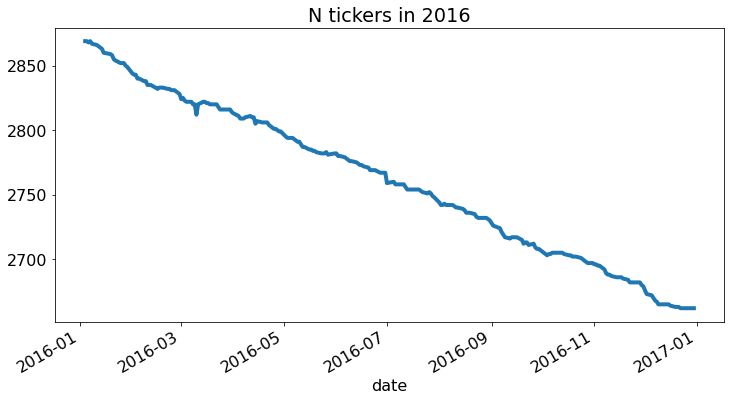

In [16]:
n_tickers['2016'].plot()
plt.title("N tickers in 2016")
plt.show()

## Pipeline

```python
def log_returns(prices: pd.Series, tau: int) -> pd.Series:
    """
    Compute log returns on time series data
    log(a/b) = log(a) - log(b)
    @param prices: time series data
    @param tau: differencing period
    @return: returns
    """

def pl_targets(data: pd.DataFrame, tau_fwd: int) -> pd.DataFrame:
    """
    Target computation on close price
    @param data: input
    @param tau_fwd: target time horizon (forward)
    @return: output
    """
 

def pl_features(data: pd.DataFrame) -> pd.DataFrame:
    """
    Compute feautures:
        x_returns_5d: 5 days momentum indicator
        x_returns_1d: 1 day momentum indicator
    :param data: input
    :return:  output
    """
    
def pl_top_vol_filter(data: pd.DataFrame, window: int, top_n: int) -> pd.DataFrame:
    """
    Compute a rolling average of ticker volume. For each day, filter top tickers 
    @param data: input
    @param window: number of periods to compute rolling mean
    @param top_n: threshold
    @return: output
    """
    

def pl_date_filter(data: pd.DataFrame, start_dt: str, end_dt: str) -> pd.DataFrame:
    """
    Apply a filter to index level `date`
    @param data: input
    @param start_dt: Filter start
    @param end_dt: Filter end
    @return: output

    """

   


## Targets

Targets is the objective variable to forecast/predict. They are computed as a **forward** price difference (return). There are many suitable ways to compute this differens:
* raw differences: p[t+tau] -p[t]
* raw-returns (pct_change): (p[t+tau] - p[t]) /p[t+tau]
* log-returns: log(p[t+tau]/p[t])

Target horizon can be determined as a function of trading strategy (how many times a year do you want to rebalance your portfolio -the more frequent, the more brokerage cost-?, what kind of variables are you going to use?

### Raw (Forward) Differences Example

In [17]:
raw_diffs = (wiki_prices
          .groupby('ticker')['adj_close']
          .diff(-tau))

In [18]:
raw_diffs.loc[ticker].head(5)

date
1997-05-16    0.2292
1997-05-19    0.1250
1997-05-20    0.1042
1997-05-21   -0.0775
1997-05-22   -0.1042
Name: adj_close, dtype: float64

In [19]:
raw_diffs.loc[ticker].tail(10)

date
2018-03-14     9.1400
2018-03-15    38.2200
2018-03-16    76.1200
2018-03-19   -10.9300
2018-03-20    89.4600
2018-03-21        NaN
2018-03-22        NaN
2018-03-23        NaN
2018-03-26        NaN
2018-03-27        NaN
Name: adj_close, dtype: float64

In [20]:
raw_diffs_ex = wiki_prices.loc[ticker, 'adj_close'].iloc[0] - wiki_prices.loc[ticker, 'adj_close'].iloc[tau]
raw_diffs_ex

0.2291666666666663

In [21]:
raw_diffs.loc[ticker].iloc[0]

0.2291666666666663

In [22]:
assert np.isclose(raw_diffs_ex, raw_diffs.loc[ticker].iloc[0])

### Raw (Forward) Returns example

In [23]:
raw_returns = (wiki_prices
          .groupby('ticker')['adj_close']
          .pct_change(-tau))

In [24]:
raw_returns_ex = (wiki_prices.loc[ticker, 'adj_close'].iloc[0]- wiki_prices.loc[ticker, 'adj_close'].iloc[tau]) / wiki_prices.loc[ticker, 'adj_close'].iloc[tau]
raw_returns_ex

0.15277777777777754

In [25]:
assert np.isclose(raw_returns_ex, raw_returns.loc[ticker].iloc[0])

### (Forward) Log Returns

In [26]:
def log_returns(prices: pd.Series, tau: int) -> pd.Series:
    """
    Compute log returns on time series data
    log(a/b) = log(a) - log(b)
    @param prices: time series data
    @param tau: differencing period
    @return: returns
    """
    return np.log(prices).diff(tau)

In [27]:
log_rets = (wiki_prices
          .groupby('ticker')['adj_close']
          .transform(lambda grp: log_returns(grp, tau=-tau))
          )

In [28]:
log_returns_ex = np.log(wiki_prices.loc[ticker, 'adj_close'].iloc[0]/wiki_prices.loc[ticker, 'adj_close'].iloc[tau])

In [29]:
log_returns_ex

0.14217448878054234

In [30]:
log_rets.loc[ticker].iloc[0]

0.1421744887805424

In [31]:
assert np.isclose(log_rets.loc[ticker].iloc[0], log_returns_ex)

In [32]:
log_rets.loc[ticker].iloc[0]

0.1421744887805424

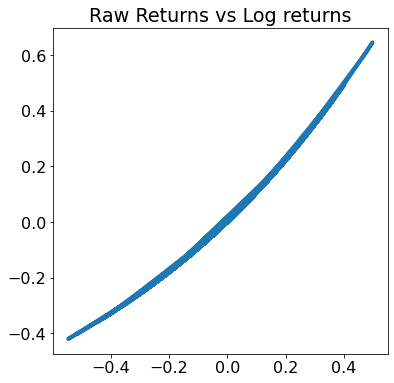

In [33]:
fig = plt.figure(figsize=(6,6))
plt.plot(log_rets.loc[ticker].values, raw_returns.loc[ticker].values)
plt.title('Raw Returns vs Log returns')
plt.show()

### Get targets

In [34]:
targets = -1*log_rets
targets.name = 'target'

In [35]:
targets.loc[ticker].iloc[0]

-0.1421744887805424

In [36]:
prices_t0_t5 = wiki_prices.loc[ticker, 'adj_close'].iloc[0], wiki_prices.loc[ticker, 'adj_close'].iloc[tau]
prices_t0_t5

(1.7291666666666663, 1.5)

In [37]:
target_ex = np.log(prices_t0_t5[1] / prices_t0_t5[0])

In [38]:
assert np.isclose(targets.loc[ticker].iloc[0], target_ex)

## Features

Features are also called **Alpha factors** (See S2 slides) and are computed on past data
Some features are based on returns (like targets, but are backwards returns), other on prices and other features on alternative data (sentiment analysis in financial analysis reports,)

In [39]:
feat_1yr_mom = (wiki_prices
            .groupby('ticker')['adj_close']
            .pct_change(252)
               )
feat_1yr_mom.name = 'x_mon_1yr'

In [40]:
feat_5d_mom = (wiki_prices
            .groupby('ticker')['adj_close']
            .apply(lambda grp: log_returns(grp, tau=5))
              )
feat_5d_mom.name = 'x_mon_5d'

In [41]:
feat_zscore = (wiki_prices
            .groupby('ticker')['adj_close']
            .transform(lambda grp: (grp - grp.rolling(20).mean())/ grp.rolling(20).std() )
              )
feat_zscore.name = 'x_price_zsco'
# this feature is interesting, research a little ;)
# z-score can also be used to transform and improve other features

In [42]:
feat_close_vs_open = wiki_prices['adj_open']-wiki_prices['adj_close']
feat_close_vs_open.name = 'x_close_vs_open'

## Join and Filter

In [43]:
features_and_targets = pd.concat([targets, feat_1yr_mom, feat_5d_mom,feat_zscore, feat_zscore, feat_close_vs_open],axis=1)
# filtering the entire population is needed in order to:
# get a subset of time
# a sample of stocks that are tradable, many options like highly traded stocks or stocks in SP500 list

# Model Building
Example Only. Actual model can be Regression or Classification

In [44]:
features_and_targets_bin = features_and_targets >=0

In [45]:
from sklearn import tree

X, y = features_and_targets_bin.filter(regex='x_'), features_and_targets_bin['target']
model = tree.DecisionTreeClassifier(max_depth=4)
model = model.fit(X, y)


In [46]:
model.classes_

array([False,  True])

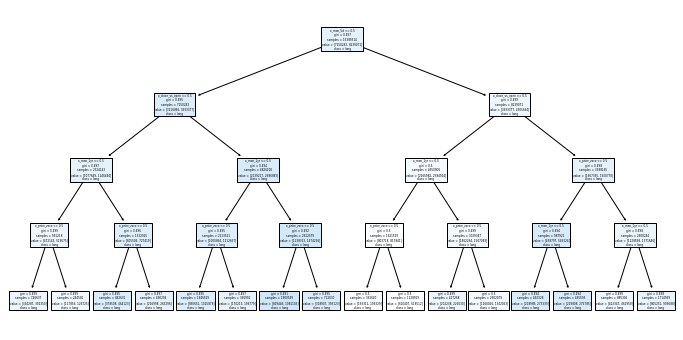

In [47]:
fig = plt.figure()
_ = tree.plot_tree(model, 
                   feature_names=X.columns,  
                   class_names=['short', 'long'],
                   filled=True)

In [48]:
alpha_ml = pd.Series(index=X.index, data=model.predict_proba(X)[:,0], name='p_alpha_ml')
# use this to device a trading strategy

# Trading strategy

One posible way to exploit the model is:
* Get probas
* apply z-score to probas
* Get portfolio weights from z-scored-probas

In [49]:
alpha_ml_day = alpha_ml.xs(level='date', key=pd.Timestamp('2018-03-27'))

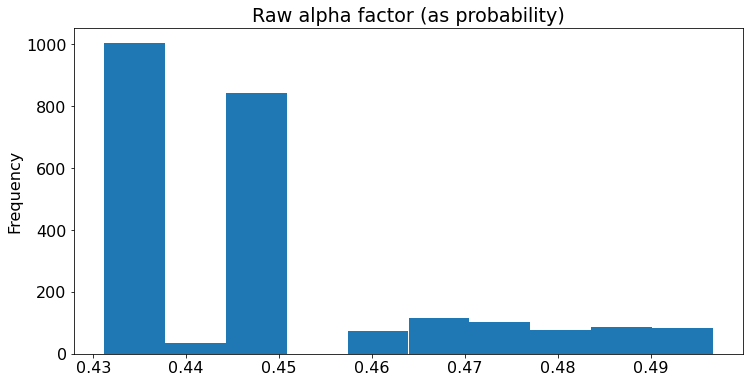

In [50]:
alpha_ml_day.plot.hist()
plt.title('Raw alpha factor (as probability)')
plt.show()

In [51]:
alpha_ml_day_zscore = (alpha_ml_day - alpha_ml_day.mean())/ alpha_ml_day.std()
# this means that the model will go long on stocks that yield a higher prob given a day distribution, even if this  proba is below 0.5

In [52]:
alpha_ml_day_portw = (alpha_ml_day_zscore / abs(alpha_ml_day_zscore).sum()).sort_values()
alpha_ml_day_portw.sum()

1.9101387138675818e-13

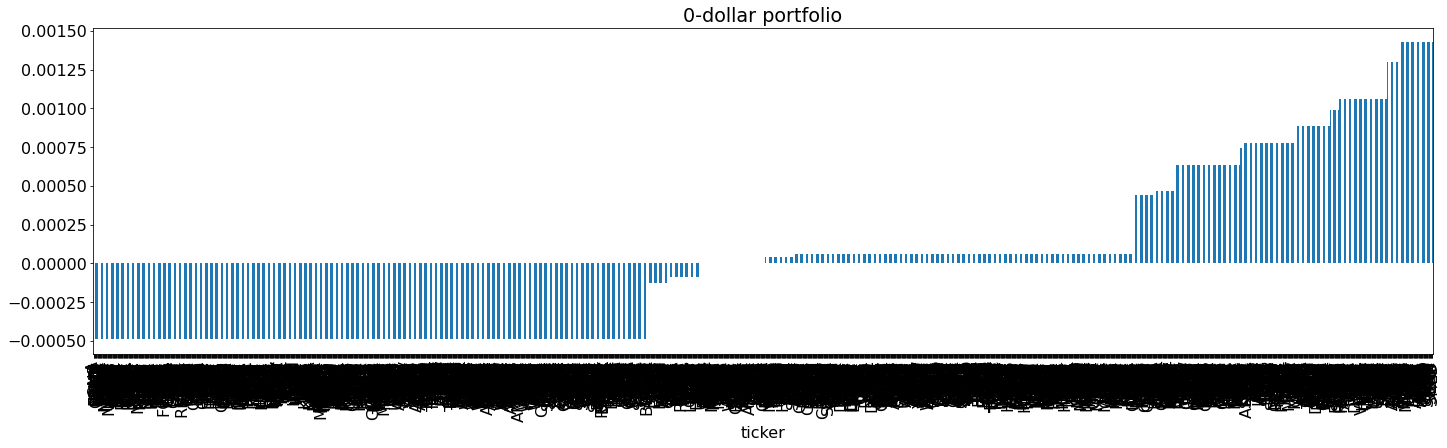

In [53]:
alpha_ml_day_portw.plot.bar(figsize=(24,6))
plt.title("0-dollar portfolio")
plt.show()
# short side tickers generate (instantly) some cash that is invested on long side tickers. No upfront investing. Short side is used as leverage (borrow cash)